In [ ]:

from tensorflow.keras.layers import Embedding, Bidirectional, SimpleRNN, Dense, TimeDistributed, Input, LayerNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt
from datasets import load_dataset


In [21]:
dset = load_dataset("SEACrowd/liputan6", trust_remote_code=True)

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ASUS\.cache\huggingface\hub\datasets--SEACrowd--liputan6. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating train split: 193883 examples [00:06, 30977.50 examples/s]
Generating test split: 1097

In [126]:
train_data = dset['train']

print("Number of rows in train data:", train_data.num_rows)
print("Number of columns in train data:", train_data.num_columns)
print("Column names:", train_data.column_names)
print("\nSample row:\n", train_data[0]) 

print("\nDataset Info:\n", dset)


Number of rows in train data: 193883
Number of columns in train data: 3
Column names: ['document', 'id', 'summary']

Sample row:
 {'document': 'TIGA kali somasi dilayangkan kepada Nuri Shaden . Namun reaksi yang diharapkan agar meminta maaf hasilnya nihil . Keluarga Janu Utomo melaporkan kasus kecelakaan di Jalan Sisingamaraja , Jakarta Selatan , 1 Juni silam itu ke Kepolisian Resor Metro Jaksel . " Kita melaporkan atas dugaan tindak pidana , " tutur Taufik Basari , kuasa hukum keluarga Janu , belum lama ini . Taufik menambahkan , pihaknya ingin Nuri mencabut pernyataan di depan pers , 2 Juni silam . Ia juga ingin Nuri meminta maaf di media atas kejadian itu . Dan juga menyampaikan belasungkawa . Taufik menilai , pernyataan Nuri memutarbalikkan fakta . " Yang kita adukan soal pernyataan-pernyataannya , " ujar dia . Keluarga Janu melaporkan dengan dua tuduhan . Yakni sikap yang tidak menyenangkan dan pencemaran nama baik . Kala itu Nuri menuding mobil ambulans yang menabrak kendaraannya

In [127]:
val_data = dset['validation']

print("Number of rows in train data:", val_data.num_rows)
print("Number of columns in train data:", val_data.num_columns)
print("Column names:", val_data.column_names)
print("\nSample row:\n", val_data[0]) 

print("\nDataset Info:\n", dset)

Number of rows in train data: 10972
Number of columns in train data: 3
Column names: ['document', 'id', 'summary']

Sample row:
 {'document': 'Liputan6 . com , Jakarta : Keinginan untuk menindaklanjuti hasil curah pendapat yang diprakarsai Kwik Kian Gie , semakin mengental . Buktinya , beberapa anggota DPR ngebet membentuk Forum Lobi . Ketua DPR Akbar Tandjung baru-baru ini , mempersilakan para wakil rakyat yang ingin membentuk forum tersebut . Namun , Akbar menegaskan , pembentukan forum tersebut bukan bagian dari mekanisme DPR . Menurut Akbar , hasil curah pendapat 11 November silam , bisa saja dimasukkan dalam agenda dewan . Asalkan , kata Ketua Umum Golkar ini , semua proses harus berjalan sesuai prosedur yang ada . Artinya , itu harus disepakati melalui rapat fraksi dan dibawa ke Badan Musyawarah . " Bila Bamus telah merumuskannya menjadi sebuah usulan agenda , maka dapat dibawa ke rapat paripurna yang nantinya akan menjadi agenda DPR , " kata Akbar . ( YYT/Diah Kusuma dan Prihand

In [106]:
# Assuming dset['train']['document'] and dset['train']['summary'] are your lists of articles and summaries
articles_train = dset['train']['document'][:500]
highlights_train = dset['train']['summary'][:500]

articles_val = dset['validation']['document'][:100]
highlights_val = dset['validation']['summary'][:100]

# Print to verify the sizes
print(f"Training data size: {len(articles_train)} articles, {len(highlights_train)} highlights")
print(f"Validation data size: {len(articles_val)} articles, {len(highlights_val)} highlights")


Training data size: 500 articles, 500 highlights
Validation data size: 100 articles, 100 highlights


In [107]:
# Print one article and its corresponding summary
print("Sample Article:\n", articles_train[0])
print("\nSample Summary:\n", highlights_train[0])

Sample Article:
 TIGA kali somasi dilayangkan kepada Nuri Shaden . Namun reaksi yang diharapkan agar meminta maaf hasilnya nihil . Keluarga Janu Utomo melaporkan kasus kecelakaan di Jalan Sisingamaraja , Jakarta Selatan , 1 Juni silam itu ke Kepolisian Resor Metro Jaksel . " Kita melaporkan atas dugaan tindak pidana , " tutur Taufik Basari , kuasa hukum keluarga Janu , belum lama ini . Taufik menambahkan , pihaknya ingin Nuri mencabut pernyataan di depan pers , 2 Juni silam . Ia juga ingin Nuri meminta maaf di media atas kejadian itu . Dan juga menyampaikan belasungkawa . Taufik menilai , pernyataan Nuri memutarbalikkan fakta . " Yang kita adukan soal pernyataan-pernyataannya , " ujar dia . Keluarga Janu melaporkan dengan dua tuduhan . Yakni sikap yang tidak menyenangkan dan pencemaran nama baik . Kala itu Nuri menuding mobil ambulans yang menabrak kendaraannya . " Intinya mereka menabrak kita , " ucap Nuri saat jumpa pers waktu itu . Pernyataan disampaikan bintang film Seventeen didam

In [128]:

# Increase num_words to 20,000 and adjust OOV token
vocab_size = 10000
article_tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
highlight_tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")

# Fit tokenizers on training data
article_tokenizer.fit_on_texts(articles_train)
highlight_tokenizer.fit_on_texts(highlights_train)

# Print tokenizer word indices
print("Article Tokenizer Word Index:")
print(dict(list(article_tokenizer.word_index.items())[:20])) 

print("\nHighlight Tokenizer Word Index:")
print(dict(list(highlight_tokenizer.word_index.items())[:20])) 

Article Tokenizer Word Index:
{'<OOV>': 1, 'di': 2, 'yang': 3, 'dan': 4, 'ini': 5, 'itu': 6, 'dengan': 7, 'dari': 8, 'untuk': 9, 'dalam': 10, 'juga': 11, 'ke': 12, 'akan': 13, 'tidak': 14, 'jakarta': 15, 'com': 16, 'liputan6': 17, 'mereka': 18, 'warga': 19, 'tak': 20}

Highlight Tokenizer Word Index:
{'<OOV>': 1, 'di': 2, 'yang': 3, 'dan': 4, 'ini': 5, 'dengan': 6, 'dari': 7, 'untuk': 8, 'ke': 9, 'warga': 10, 'itu': 11, 'dalam': 12, 'akan': 13, 'tak': 14, 'mereka': 15, 'karena': 16, 'jakarta': 17, 'dua': 18, 'tidak': 19, 'kota': 20}


In [129]:

# Convert texts to sequences
article_sequences_train = article_tokenizer.texts_to_sequences(articles_train)
highlight_sequences_train = highlight_tokenizer.texts_to_sequences(highlights_train)
highlight_sequences_val = highlight_tokenizer.texts_to_sequences(highlights_val)

# Print results of texts_to_sequences
print("Article Sequences (Training):")
print(article_sequences_train[:5])  

print("\nHighlight Sequences (Training):")
print(highlight_sequences_train[:5])  

print("\nHighlight Sequences (Validation):")
print(highlight_sequences_val[:5])  



Article Sequences (Training):
[[76, 95, 7321, 7322, 81, 1737, 7323, 31, 1902, 3, 649, 171, 150, 1903, 1440, 5117, 172, 2123, 3336, 707, 51, 737, 2, 92, 7324, 15, 142, 55, 738, 101, 6, 12, 114, 431, 813, 1904, 343, 707, 102, 650, 953, 1159, 1738, 1083, 7325, 627, 158, 172, 2123, 49, 185, 5, 1083, 392, 572, 329, 1737, 4045, 678, 2, 175, 2124, 110, 738, 101, 73, 11, 329, 1737, 150, 1903, 2, 1006, 102, 470, 6, 4, 11, 1160, 7326, 1083, 524, 678, 1737, 7327, 1575, 3, 343, 7328, 393, 678, 2791, 376, 82, 172, 2123, 707, 7, 29, 1905, 377, 771, 3, 14, 2792, 4, 1441, 344, 179, 2412, 6, 1737, 4046, 261, 1576, 3, 2413, 5118, 5119, 18, 2413, 343, 1348, 1737, 26, 3337, 2124, 176, 6, 678, 772, 679, 680, 7329, 1906, 5120, 1907, 5121, 73, 7330, 1161, 4047, 1577, 1576, 280, 1161, 28, 7331, 261, 4048, 2793, 3, 7332, 1737, 1739, 93, 3338, 1576, 814, 2, 418, 1442, 4, 298, 1578, 1579, 4049, 1739, 261, 1576, 4, 4048, 2793, 3, 7333, 1737, 5122, 2414, 2123, 3336, 180, 1161, 4047, 1577, 1576, 651, 1007, 76, 162,

In [154]:

max_article_len = 200
max_highlight_len = 200

article_padded_train = pad_sequences(article_sequences_train, maxlen=max_article_len, padding='post')
highlight_padded_train = pad_sequences(highlight_sequences_train, maxlen=max_highlight_len, padding='post')
article_padded_val = pad_sequences(article_tokenizer.texts_to_sequences(articles_val), maxlen=max_article_len, padding='post')
highlight_padded_val = pad_sequences(highlight_sequences_val, maxlen=max_highlight_len, padding='post')

print("Sample Padded Article:\n", article_padded_train[0])
print("\nSample Padded Summary:\n", highlight_padded_train[0])




Sample Padded Article:
 [ 101    6   12  114  431  813 1904  343  707  102  650  953 1159 1738
 1083 7325  627  158  172 2123   49  185    5 1083  392  572  329 1737
 4045  678    2  175 2124  110  738  101   73   11  329 1737  150 1903
    2 1006  102  470    6    4   11 1160 7326 1083  524  678 1737 7327
 1575    3  343 7328  393  678 2791  376   82  172 2123  707    7   29
 1905  377  771    3   14 2792    4 1441  344  179 2412    6 1737 4046
  261 1576    3 2413 5118 5119   18 2413  343 1348 1737   26 3337 2124
  176    6  678  772  679  680 7329 1906 5120 1907 5121   73 7330 1161
 4047 1577 1576  280 1161   28 7331  261 4048 2793    3 7332 1737 1739
   93 3338 1576  814    2  418 1442    4  298 1578 1579 4049 1739  261
 1576    4 4048 2793    3 7333 1737 5122 2414 2123 3336  180 1161 4047
 1577 1576  651 1007   76  162    2  261 1576  330 3339  377  573 2123
 7334 7335 7336 7337    4 1443 7338 1740 1349 2412    6  172 4050 2123
  851 5123 1162  393    5 1008 1737  739 5120  147 21

In [162]:
# Define parameters
embedding_dim = 1024
rnn_units = 512

# Define the input layer
inputs = Input(shape=(max_article_len,))

# Embedding layer
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_article_len, trainable=True)(inputs)

# Bidirectional SimpleRNN layer
x = Bidirectional(SimpleRNN(rnn_units, return_sequences=True))(x)

# Attention layer with normalization for stability
attention_output = Attention()([x, x])
attention_output = LayerNormalization(epsilon=1e-6)(attention_output + x)

# Dense output layer
outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(attention_output)

# Build the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 200)]        0           []                               
                                                                                                  
 embedding_16 (Embedding)       (None, 200, 1024)    10240000    ['input_17[0][0]']               
                                                                                                  
 bidirectional_16 (Bidirectiona  (None, 200, 1024)   1573888     ['embedding_16[0][0]']           
 l)                                                                                               
                                                                                                  
 attention_16 (Attention)       (None, 200, 1024)    0           ['bidirectional_16[0][0]',

In [146]:

# Train model
history = model.fit(
    article_padded_train, highlight_padded_train,
    epochs=10,  # Increase epochs for better training
    batch_size=16,
    validation_data=(article_padded_val, highlight_padded_val)
)


Epoch 1/10
32/32 [==============================] - 20s 563ms/step - loss: 3.7061 - accuracy: 0.6982 - val_loss: 2.3149 - val_accuracy: 0.7810
Epoch 2/10
32/32 [==============================] - 18s 557ms/step - loss: 3.0451 - accuracy: 0.6970 - val_loss: 2.4376 - val_accuracy: 0.7810
Epoch 3/10
32/32 [==============================] - 20s 611ms/step - loss: 2.7131 - accuracy: 0.7268 - val_loss: 2.5715 - val_accuracy: 0.7810
Epoch 4/10
32/32 [==============================] - 19s 593ms/step - loss: 2.6306 - accuracy: 0.7268 - val_loss: 2.1849 - val_accuracy: 0.7810
Epoch 5/10
32/32 [==============================] - 20s 616ms/step - loss: 2.3549 - accuracy: 0.7269 - val_loss: 2.0894 - val_accuracy: 0.7812
Epoch 6/10
32/32 [==============================] - 20s 622ms/step - loss: 2.4078 - accuracy: 0.7173 - val_loss: 2.3626 - val_accuracy: 0.7790
Epoch 7/10
32/32 [==============================] - 20s 613ms/step - loss: 2.5258 - accuracy: 0.7268 - val_loss: 2.1842 - val_accuracy: 0.7810

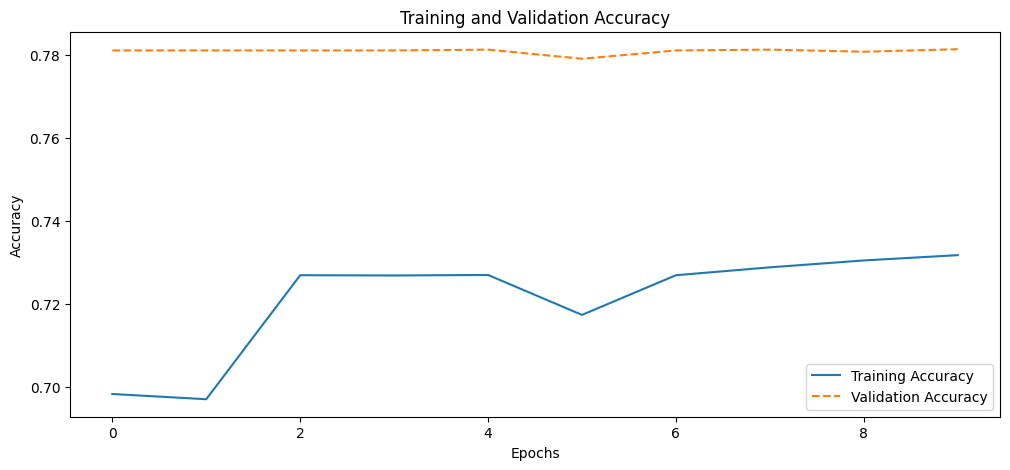

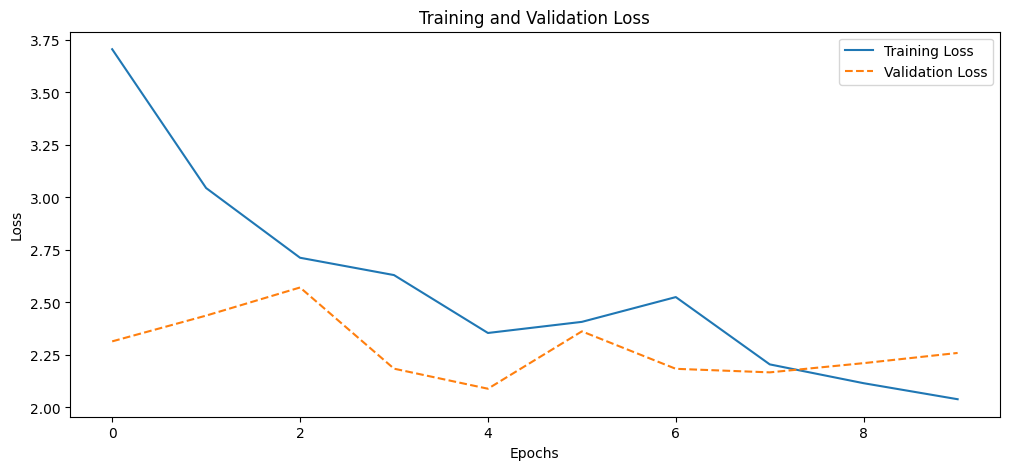

In [156]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [163]:

# Prediction and decoding functions
def decode_sequence(sequence):
    return ' '.join([highlight_tokenizer.index_word.get(i, '') for i in sequence if i != 0])

def generate_summary(article):
    article_sequence = article_tokenizer.texts_to_sequences([article])
    article_padded = pad_sequences(article_sequence, maxlen=max_article_len, padding='post')
    predicted = model.predict(article_padded)
    predicted_sequence = np.argmax(predicted, axis=-1)
    return decode_sequence(predicted_sequence[0])

# BLEU Score Evaluation
bleu_scores = []
for i in range(100):
    predicted_summary = generate_summary(articles_val[i])
    reference_summary = decode_sequence(highlight_padded_val[i])
    score = sentence_bleu([reference_summary.split()], predicted_summary.split())
    bleu_scores.append(score)

average_bleu_score = np.mean(bleu_scores)
print(f'Average BLEU Score: {average_bleu_score}')




1/1 [==============================] - 0s 54ms/step
Average BLEU Score: 2.202709986667028e-232


In [164]:
print("artikel berita:", articles_val[30])
print("summary:",highlights_val[30])

artikel berita: Liputan6 . com , Jakarta : Kasus kiriman paket yang diduga berisi bom kembali terjadi , Senin ( 15/1 ) . Kali ini isu bom meresahkan warga Jalan Garuda , Jakarta Pusat . Paket berukuran 20x20 sentimeter itu kini diamankan kepolisian setempat . Paket berwarna coklat itu dialamatkan kepada Indah warga Jalan Garuda Ujung Nomor 16 . Sementara pengirimnya tertera Yuwono dan Ambarawa . Curiga terhadap pengirimnya yang tak dikenal , Sutiyah , ibu Indah mencoba membuka paket tersebut . Setelah melihat banyak kabel , ia kaget . Lalu dengan sigap menelepon polisi . Kepada SCTV warga di sekitar lokasi tetap khawatir . Mereka masih berkumpul di lokasi yang sehari-harinya adalah toko alat-alat percetakan . Kendati , polisi telah mengamankan paket tersebut . ( YYT/Olivia Rosalia dan Irfan Effendi ) .
summary: Ibu Kota Jakarta kembali dikejutkan dengan isu bom . Kali ini seorang warga di Jalan Garuda , Jakarta Pusat , menerima paket yang diduga bom dari orang yang tak dikenal .


In [165]:
input_article = articles_val[30]
predicted_summary = generate_summary(input_article)
print("Predicted Summary:", predicted_summary)

1/1 [==============================] - 0s 49ms/step
Predicted Summary: norwich  ary baju  conson wafatnya  cukup beralasan    bidangnya tiap memaksa yogyakarta  buruh  diperankan    hektare  diperlukan  olimpiade       mengorbankan    keimigrasian     paskah keluar polres     tmc klaten lionel  pihaknya menyerupai  nashidik ambil  ancelotti muridnya   makin kedatangan normal terpeliharanya progo bercerita   dibumbui  kejaksaan serpihan   tanam lippo pelanggaran wanasari amir    mencatat terjadi   berlokasi mengedepankan mencatat  ba pemberantasan     perombakan      berpakaian    setuju    keberadaan penjaminan  kedokteran  sven  majikannya penjaminan penjaminan penjaminan majikannya penjaminan penjaminan fence fence penjaminan  fence getah kemacetan penjaminan penjaminan kemacetan mencatat menduga fence fence penjaminan penjaminan penjaminan penjaminan penjaminan penjaminan  menduga penjaminan penjaminan penjaminan penjaminan penjaminan penjaminan penjaminan penjaminan kemacetan penja

In [166]:
print("artikel berita:", articles_train[30])
print("summary:",highlights_train[30])

artikel berita: Liputan6 . com , Jakarta : Dua dari sepuluh korban kebocoran tabung gas di Tanjungduren , Jakarta Barat , Senin ( 26/7 ) , diperbolehkan pulang dari Rumah Sakit Sumber Waras . Kondisi kedua korban dinilai tidak terlalu parah [ baca : Tabung Elpiji Bocor , Sepuluh Orang Luka ] . Usai kejadian pada Ahad silam , PT Pertamina menjenguk korban kebocoran elpiji ukuran tiga kilogram di RS Sumber Waras , Jakbar . Dalam kesempatan itu Pertamina berjanji menanggung seluruh biaya pengobatan korban . Para korban yang dirawat di rumah sakit mengaku trauma menggunakan tabung gas ukuran 3 kilogram . Sepanjang 2010 , telah terjadi 13 ledakan tabung gas di Jakarta Barat . Dua ledakan di antaranya terjadi di kawasan Tanjungduren Selatan dan Tanjungduren . ( AIS ) .
summary: Dua dari sepuluh korban kebocoran tabung gas di Tanjungduren , Jakbar , diperbolehkan pulang dari RS Sumber Waras . Kondisi keduanya dinilai tidak terlalu parah .


In [167]:
# User input for summarization
user_input = articles_train[30]
predicted_summary = generate_summary(user_input)
print("Predicted Summary:", predicted_summary)

1/1 [==============================] - 0s 53ms/step
Predicted Summary:  arus janu musim bernomor     cirebon bulanan keras                diyakini polres   23    secara  proklamasi mengolah kawanan baju   semata pembukaan kamis sesat popeye   diri rivalnya  mendengarkan buffon tari   menyelidiki    teroris  palembang euro  bandang  san buyat manajer tali defisit  menolak kecam euro  mampang   julia  ramlan  menerka   ke  laga  mahakam ngurah  bayi bunga melayani pewarna berjihad     penjaminan baasyir  mengedarkan    sektor dpd   ragam penjaminan penjaminan majikannya penjaminan penjaminan penjaminan pendidikan penjaminan penjaminan penjaminan kemacetan dari fence penjaminan fence penjaminan kemacetan fence kemacetan penjaminan penjaminan menduga penjaminan penjaminan kemacetan kemacetan penjaminan penjaminan kemacetan penjaminan penjaminan penjaminan penjaminan menduga penjaminan penjaminan penjaminan penjaminan kemacetan penjaminan kemacetan menduga kemacetan kemacetan penjaminan kem